In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [3]:
eyes_closed = np.load('/homes/v20subra/S4B2/eLORETA_extensive_validation/eyes_closed_20o_twosecond_randomly_reg.npy',allow_pickle='True')
eyes_open = np.load('/homes/v20subra/S4B2/eLORETA_extensive_validation/eyes_open_20o_twosecond_randomly_reg.npy',allow_pickle='True')

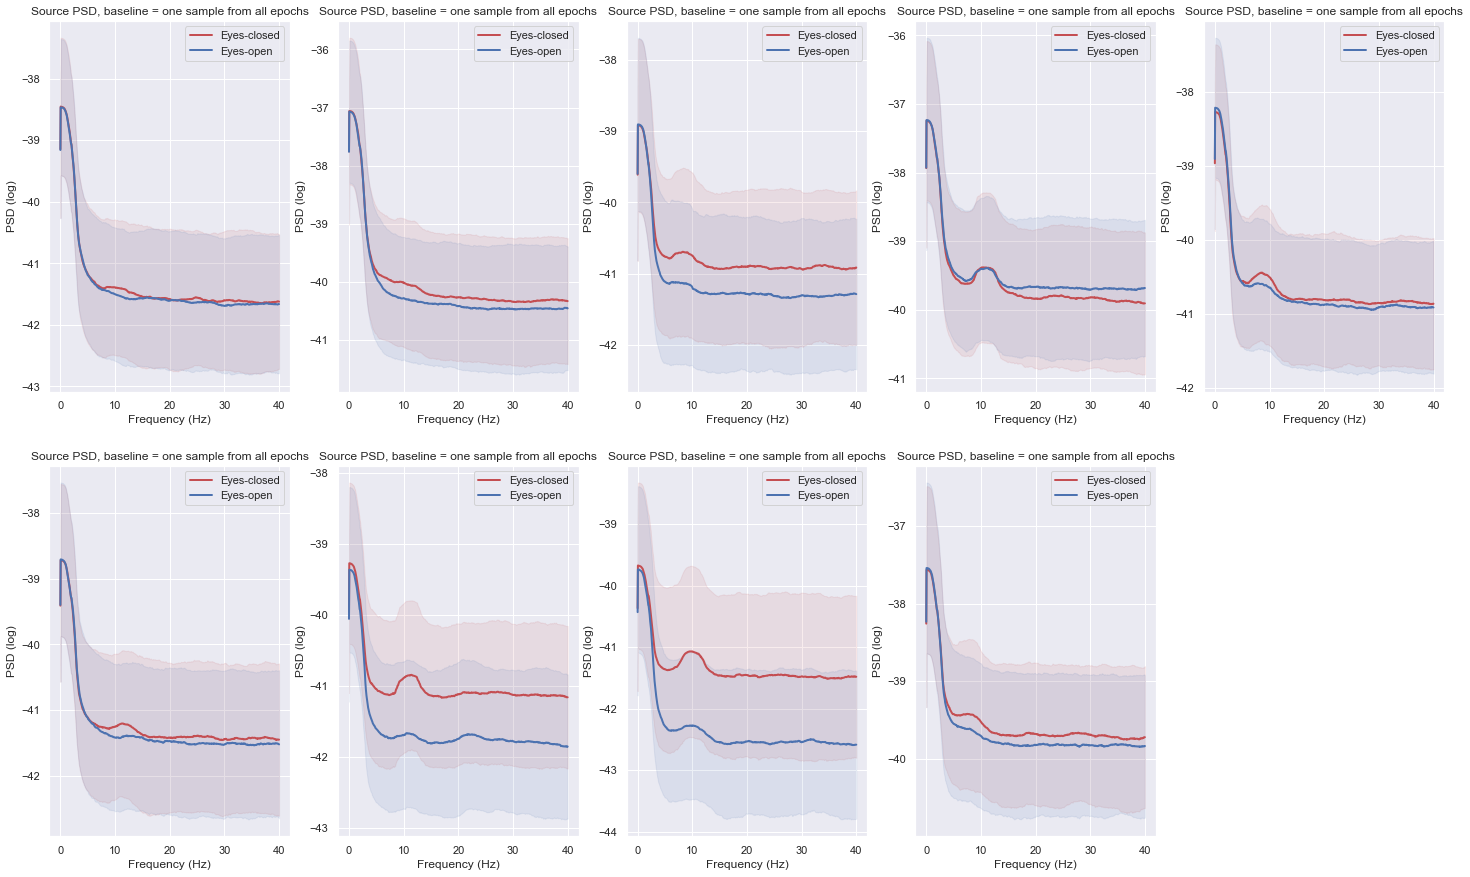

In [5]:
import seaborn as sns
sns.set_theme()
def mean_std(data1):

    m = np.mean(np.log(data1.data.T),axis=1)
    s = 2 * np.std(np.log(data1.data.T),axis=1)
    top = m+s
    bottom = m-s
    return m,s,top,bottom
stcs_to_plot = [eyes_closed.item(),eyes_open.item()]
#def lowISC_high_ISC(*typ):
a = 2  # number of rows
b = 5  # number of columns
fig =plt.figure(figsize=(25,15))

c = 1  # initialize plot counter
for i in range(9):
    
    axx1 = plt.subplot(a, b, c)

    m,s,top,bottom= mean_std(stcs_to_plot[0][i])
    axx1.plot(stcs_to_plot[0][i].times,m, linewidth=2,color='r',label='Eyes-closed') 
    axx1.fill_between(stcs_to_plot[0][i].times,bottom, top, color='r', alpha=.1)

    m,s,top,bottom= mean_std(stcs_to_plot[1][i])
    axx1.plot(stcs_to_plot[1][i].times,m, linewidth=2,color='b',label='Eyes-open')
    axx1.fill_between(stcs_to_plot[1][i].times,bottom, top, color='b', alpha=.1)
    axx1.legend()

    plt.xlabel('Frequency (Hz)')
    plt.ylabel('PSD (log)')
    plt.title('Source PSD, baseline = one sample from all epochs')

    c = c + 1
plt.show()
#fig.savefig('/homes/v20subra/S4B2/eLORETA_extensive_validation/eloreta_setup_validation_event_onesample.png')


In [6]:
import mne
import pathlib
from mne.externals.pymatreader import read_mat
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import axes3d

subjects = ['NDARCD401HGZ','NDARDX770PJK', 'NDARGY054ENV', 'NDARMR242UKQ', 'NDARRD720XZK', 'NDARTR840XP1', 'NDARXJ696AMX', 'NDARYY218AGA', 'NDARZP564MHU']

def csv_to_raw_mne(path_to_file,path_to_montage_ses,fs,path_to_events,montage = 'GSN-HydroCel-129'):
    ''' Load csv files of data, chan locations and events and return a raw mne instance'''
    data = np.loadtxt(path_to_file,delimiter =',')
    chans = pd.read_csv(path_to_montage_ses,sep = ',',header = None)
    
    ch_names = list(chans.values[1:,0])
#print(type(ch_names))
    ch_names_appended = list(np.append(ch_names,'stim_channel'))

    types = ['eeg']*(len(ch_names_appended)-1)
    types.append('stim')
    data2 = np.zeros([1,len(data[0])]) #len(raw.times)
    data_appended = np.append(data,data2,axis = 0)

    #print(np.shape(data_appended))
#print(len(types))

#types
    info = mne.create_info(ch_names_appended,sfreq = fs,ch_types = types)
#raw=mne.io.RawArray(data, info)

#mne.find_events(raw,stim_channel='stim')
    raw = mne.io.RawArray(data_appended, info)
    
    # set standard montage
    if montage:
        raw.set_montage(montage)
        raw.set_eeg_reference(projection=True) 
        raw.apply_proj()
    # events array shape must be (n_events,3)The first column specifies the sample number of each event,
    # the second column is ignored, and the third column provides the event value.
    # If events already exist in the Raw instance at the given sample numbers, the event values will be added together.

    if path_to_events:
        # parse events file
        raw_events = pd.read_csv(path_to_events, sep = r'\s*,\s*', header = None, engine = 'python')
        values = raw_events[0].to_list()
    
        # identify markers start and stop recording
        idx = [i for i, e in enumerate(values) if e == 'break cnt']

        samples = raw_events[1][idx[0] + 1:idx[1]].to_numpy(dtype = int)
        # slicing until '-1' means that we will not know about the last state. Hence removed.
        event_values = raw_events[0][idx[0] + 1:idx[1]].to_numpy(dtype = int)

        
        # append a last value for end of paradigm
        ## I think 1 acts as an explicit EOF, but having this slicing until '-1' as indicated
        # in the previous comment would not let us know the last state
        # event_values = np.append(event_values, 1)

        # Creating an array of len(samples)-1 would not have the sufficient length to add the 
        # sample's last row.
        events = np.zeros((len(samples), 3))
        
        events = events.astype('int')
        events[:, 0] = samples
        events[:, 2] = event_values
        
        # Appending one row of 'ones'. Will be easier to stop parsing once we hit 1
        events_final = np.append(events,np.ones((1, 3)),axis = 0).astype('int')
        raw = exclude_channels_from_raw(raw, ch_list)
        raw.add_events(events[:-1], stim_channel = 'stim_channel',replace = False)
    return raw,events_final

def exclude_channels_from_raw(raw,ch_to_exclude):
    '''Return a raw structure where ch_to_exclude are removed'''
    idx_keep = mne.pick_channels(raw.ch_names,include = raw.ch_names,exclude = ch_to_exclude)
    raw.pick_channels([raw.ch_names[pick] for pick in idx_keep])
    
    return raw


raw_loaded_data = dict()
events_loaded_data = dict()
for i in range(9):
    subject = subjects[i]
    path_to_file = '/users/local/Venkatesh/HBN/%s/EEG/preprocessed/csv_format/RestingState_data.csv'%subject
    path_to_events = '/users/local/Venkatesh/HBN/%s/EEG/preprocessed/csv_format/RestingState_event.csv'%subject
    path_to_montage_glob = '/users/local/Venkatesh/HBN/GSN_HydroCel_129_hbn.sfp'
    path_to_montage_ses = '/users/local/Venkatesh/HBN/%s/EEG/preprocessed/csv_format/RestingState_chanlocs.csv'%subject
    fs = 500
    chans_glob = mne.channels.read_custom_montage(fname = '/users/local/Venkatesh/HBN/GSN_HydroCel_129_hbn.sfp') # read_montage is deprecated
    # channels to exclude because noisy (Nentwich paper)
    ch_list=['E1', 'E8', 'E14', 'E17', 'E21', 'E25', 'E32', 'E38', 'E43', 'E44', 'E48', 'E49', 'E56', 'E57', 'E63', 'E64', 'E69', 'E73', 'E74', 'E81', 'E82', 'E88', 'E89', 'E94', 'E95', 'E99', 'E100', 'E107', 'E113', 'E114', 'E119', 'E120', 'E121', 'E125', 'E126', 'E127', 'E128']


    raw_loaded_data[i], events_loaded_data[i] = csv_to_raw_mne(path_to_file,path_to_montage_ses,fs,path_to_events,montage = 'GSN-HydroCel-129')


Creating RawArray with float64 data, n_channels=112, n_times=185185
    Range : 0 ... 185184 =      0.000 ...   370.368 secs
Ready.
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Creating RawArray with float64 data, n_channels=112, n_times=202806
    Range : 0 ... 202805 =      0.000 ...   405.610 secs
Ready.
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Creating RawArray with float64 data, n_channels=112, n_times=188133
    Range : 0 ... 188132 =      0.000 ...   376.264 secs
Ready.
Adding average EEG reference proje

In [7]:
epochs_resampled = dict()
for i in range(9):
    epochs = mne.Epochs(raw_loaded_data[i], events_loaded_data[i], [20,30,90], tmin=0, tmax=20,preload=True,baseline=(0,None))
    epochs_resampled[i] = epochs.resample(250) # Downsampling to 250Hz


Not setting metadata
Not setting metadata
12 matching events found
Setting baseline interval to [0.0, 20.0] sec
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 12 events and 10001 original time points ...
1 bad epochs dropped
Not setting metadata
Not setting metadata
12 matching events found
Setting baseline interval to [0.0, 20.0] sec
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 12 events and 10001 original time points ...
1 bad epochs dropped
Not setting metadata
Not setting metadata
12 matching events found
Setting baseline interval to [0.0, 20.0] sec
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 12 events and 10001 original time points ...
1 bad epochs dropped
Not setting metadata
Not setting metadata
12 matching e

    Using multitaper spectrum estimation with 7 DPSS windows
Need more than one channel to make topography for eeg. Disabling interactivity.
    Using multitaper spectrum estimation with 7 DPSS windows
Need more than one channel to make topography for eeg. Disabling interactivity.
    Using multitaper spectrum estimation with 7 DPSS windows
Need more than one channel to make topography for eeg. Disabling interactivity.
    Using multitaper spectrum estimation with 7 DPSS windows
Need more than one channel to make topography for eeg. Disabling interactivity.
    Using multitaper spectrum estimation with 7 DPSS windows
Need more than one channel to make topography for eeg. Disabling interactivity.
    Using multitaper spectrum estimation with 7 DPSS windows
Need more than one channel to make topography for eeg. Disabling interactivity.
    Using multitaper spectrum estimation with 7 DPSS windows
Need more than one channel to make topography for eeg. Disabling interactivity.
    Using mul

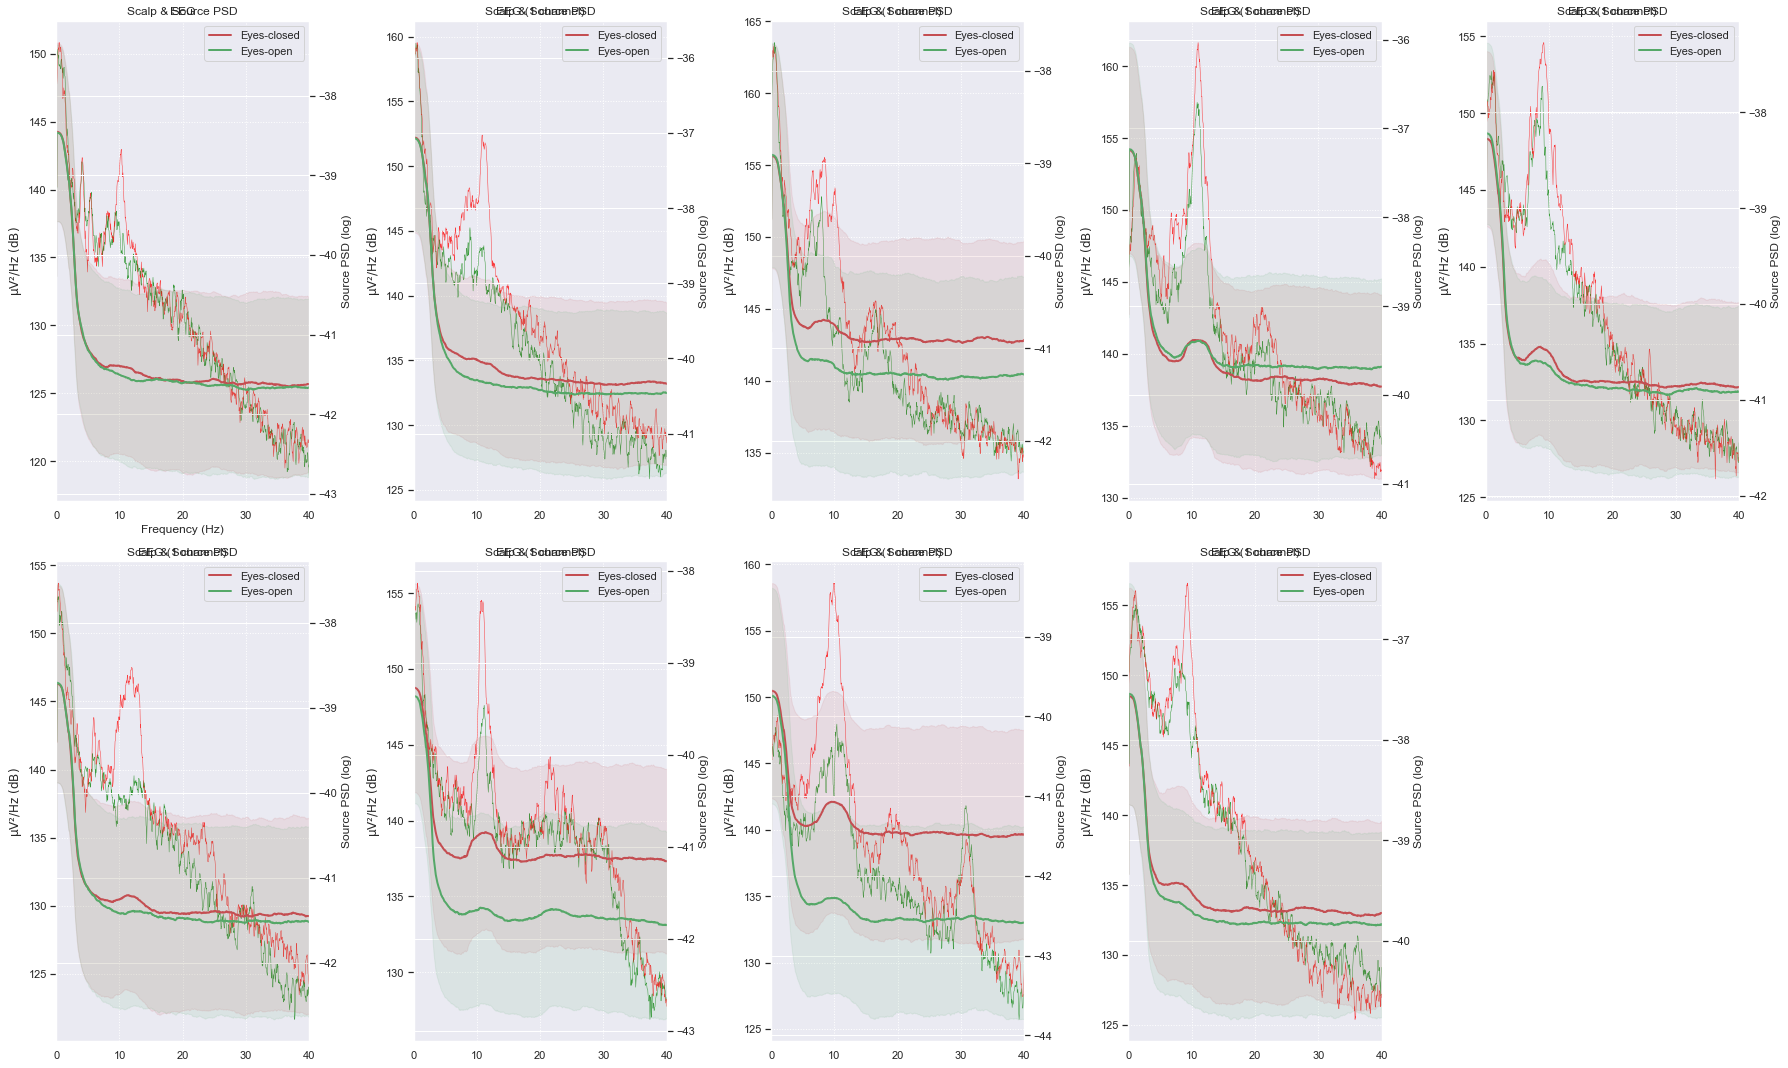

In [8]:
a = 2  # number of rows
b = 5  # number of columns
fig =plt.figure(figsize=(25,15))



c = 1  # initialize plot counter
for i in range(9):
    
  
    axx = plt.subplot(a, b, c)
    one = epochs_resampled[i]['20'].plot_psd(tmax=20,fmax=40,picks=['E65'],show=False,ax=axx,color='green',spatial_colors=False)
    two = epochs_resampled[i]['30'].plot_psd(tmax=20,fmax=40,picks=['E65'],show=False,ax=axx,color='red',spatial_colors=False)

    axx1 = axx.twinx()  # instantiate a second axes that shares the same x-axis

    m,s,top,bottom= mean_std(stcs_to_plot[0][i])
    axx1.plot(stcs_to_plot[0][i].times,m, linewidth=2,color='r',label='Eyes-closed') 
    axx1.fill_between(stcs_to_plot[0][i].times,bottom, top, color='r', alpha=.1)

    m,s,top,bottom= mean_std(stcs_to_plot[1][i])
    axx1.plot(stcs_to_plot[1][i].times,m, linewidth=2,color='g',label='Eyes-open')
    axx1.fill_between(stcs_to_plot[1][i].times,bottom, top, color='g', alpha=.1)
    axx1.legend()
    axx1.tick_params(axis='y')

    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Source PSD (log)')
    plt.title('Scalp & Source PSD')
    c = c+1
fig.tight_layout()
plt.show()
#fig.savefig('/homes/v20subra/S4B2/eLORETA_extensive_validation/eloreta_setup_validation_event_randompickings_twosecondsAt20o_rand.png')
